# Occultation Class

The `Occultation` Object Class within SORA was created to reduce and analyze stellar occultations, and control all the other Object Classes at SORA package. Here we have some useful tasks that allow converting the times for each observatory in positions in the sky plane ($\xi$, $\eta$), fit an ellipse to the points, obtain the astrometrical position resulting, among others.

The documentation <a href=https://sora.readthedocs.io/>here</a> contains the details about every step.  

This Jupyter-Notebook was designed as a tutorial for how to work with the `Occultation` Object Class. More information about the other classes, please refer to their specif Jupyter-Notebook. Any further question, please contact the core team: Altair Ramos Gomes Júnior, Bruno Eduardo Morgado, Gustavo Benedetti Rossi, and Rodrigo Carlos Boufleur.

**The** `Occultation` **Docstring was designed to help the users. Also, each function has its Docstring containing its main purpose and the needed parameters (physical description and formats). Please, do not hesitate to use it.**

## 0. Index

1. [Instantiating the Occultation Object and adding observations](#section_1)

2. [Projecting the times in the sky plane and the Chords](#section_2)

3. [Ellipse fit](#section_3)

4. [Viewing and saving the results](#section_4)

In [2]:
## SORA package
from sora import Occultation, Body, Star, LightCurve, Observer

## Other main packages
#from astropy.time import Time
import astropy.units as u

## Usual packages
import numpy as np
import matplotlib.pylab as pl
import os

<a id="section_1"></a>

## 1. Instantiating the Occultation Object and adding observations

The `Occultation` Object Class can be instantiated in only one way. For this it is needed a `Star` Object, an `Body` Object with a `Ephemeris` Object (`EphemKernel`, `EphemPlanet` or `EphemHorizons`), and the occultation time (within 60 minutes of the correct value).

In [2]:
Occultation?

Init signature: Occultation(star, body=None, ephem=None, time=None)
Docstring:     
Does the reduction of the occultation
    
Init docstring:
Instantiates the Occultation object.

Parameters:
    star (Star, str): The coordinate of the star in the same reference frame as the ephemeris.
        It must be a Star object or a string with the coordinates of the object to search on
        Vizier (required).
    body* (Body, str): Object that will occult the star. It must be a Body object or its
        name to search in the Small Body Database.
    ephem* (Ephem): object ephemeris. It must be an Ephemeris object or a list .
    time (str, Time): Reference time of the occultation.
        Time does not need to be exact, but needs to be within approximately 50 minutes
        of the occultation closest approach to calculate occultation parameters (required).

* When instantiating with "body" and "ephem", the user may define the Occultation in 3 ways:
    - With "body" and "ephem".
    - Wit

**First let's instanciate the** `Star` **and the** `Body`

SORA will automatically search for the star information. A warning will raise when any information is missing. In this example, there is no star radius available in Gaia.

In [3]:
chariklo = Body(name='Chariklo', 
                ephem=['input/bsp/Chariklo.bsp', 'input/bsp/de438_small.bsp'])

star_occ  = Star(coord='18 55 15.65250 -31 31 21.67051') # Occ Chariklo 22-06-2017

Obtaining data for Chariklo from SBDB

1 Gaia-EDR3 star found G=14.223702
star coordinate at J2016.0: RA=18h55m15.65210s +/- 0.0197 mas, DEC=-31d31m21.6676s +/- 0.018 mas



**Now, we can instantiate the Occultation**

In [4]:
occ = Occultation(star=star_occ, body=chariklo, time='2017-06-22 21:18')

print(occ)

Stellar occultation of star Gaia-DR2 6760223758801661440 by 10199 Chariklo (1997 CU26).

Geocentric Closest Approach: 0.049 arcsec
Instant of CA: 2017-06-22 21:18:48.200
Position Angle: 359.72 deg
Geocentric shadow velocity: -22.00 km / s
Sun-Geocenter-Target angle:  166.42 deg
Moon-Geocenter-Target angle: 149.11 deg


No observations reported

###############################################################################
                                     STAR                                      
###############################################################################
Gaia-EDR3 star Source ID: 6760223758801661440
ICRS star coordinate at J2016.0:
RA=18h55m15.65210s +/- 0.0197 mas, DEC=-31d31m21.6676s +/- 0.0180 mas
pmRA=3.556 +/- 0.025 mas/yr, pmDEC=-2.050 +/- 0.020 mas/yr
Plx=0.2121 +/- 0.0228 mas, Rad. Vel.=0.00 +/- 0.00 km/s 

Magnitudes: G: 14.224, B: 14.320, V: 13.530, R: 14.180, J: 12.395, H: 11.781,
            K: 11.627

Apparent diameter from Kervella et. al (2004):

**Note that at the** `print(Occultation)` **there are no observations added to this** `Occultation` **yet.**

It is needed one `Observer` and one `LightCurve` to define an `Chord`.

**Let's instanciate the** `Observers`

Here we will give 5 locations

In [5]:
out = Observer(name='Outeniqua'  ,lon='+16 49 17.710', lat='-21 17 58.170', height =1416)
ond = Observer(name='Onduruquea' ,lon='+15 59 33.750', lat='-21 36 26.040', height =1220)
tiv = Observer(name='Tivoli'     ,lon='+18 01 01.240', lat='-23 27 40.190', height =1344)
whc = Observer(name='Windhoek'   ,lon='+17 06 31.900', lat='-22 41 55.160', height =1902)
hak = Observer(name='Hakos'      ,lon='+16 21 41.320', lat='-23 14 11.040', height =1843)

**Let's instanciate the** `LightCurves`

Here we give 6 light curves. Note that 2 are for the same site observed with different telescopes.

In [6]:
#INCREASE THE ERRORS!!!!

out_lc = LightCurve(name='Outeniqua lc',
                    initial_time='2017-06-22 21:20:00.056',
                    end_time ='2017-06-22 21:29:59.963',
                    immersion='2017-06-22 21:21:20.329',immersion_err=0.320,
                    emersion ='2017-06-22 21:21:30.343',emersion_err=0.340)

ond_lc = LightCurve(name='Onduruquea lc',
                    initial_time='2017-06-22 21:11:52.175',
                    end_time ='2017-06-22 21:25:13.389',
                    immersion='2017-06-22 21:21:22.213',immersion_err=0.100,
                    emersion ='2017-06-22 21:21:33.824',emersion_err=0.110)

tiv_lc = LightCurve(name='Tivoli lc',
                    initial_time='2017-06-22 21:16:00.094',
                    end_time ='2017-06-22 21:28:00.018',
                    immersion='2017-06-22 21:21:15.628',immersion_err=0.700,
                    emersion ='2017-06-22 21:21:19.988',emersion_err=0.700)

whc_c14_lc = LightCurve(name='Windhoek C14 lc',
                    initial_time='2017-06-22 21:12:48.250',
                    end_time ='2017-06-22 21:32:47.963',
                    immersion='2017-06-22 21:21:17.609',immersion_err=0.240,
                    emersion ='2017-06-22 21:21:27.564',emersion_err=0.260)

whc_d16_lc = LightCurve(name='Windhoek D16 lc',
                    initial_time='2017-06-22 21:20:01.884',
                    end_time ='2017-06-22 21:22:21.894',
                    immersion='2017-06-22 21:21:17.288',immersion_err=0.280,
                    emersion ='2017-06-22 21:21:27.228',emersion_err=0.340)

hak_lc = LightCurve(name='Hakos lc',
                    initial_time='2017-06-22 21:10:19.461',
                    end_time ='2017-06-22 21:30:19.345')

**To add the observation to the** `Occultation` **just use the** `Occultation.chords.add_chord()`

During this step the `LightCurve` is automatic updated using the `Occultation` parameters: the Shadow's velocity, the star diameter and the distance to the occulting body. This means that is no need for the user to do the `LightCurve.set_dist()`, `LightCurve.set_vel()` and `LightCurve.set_star_diam()`.

In [7]:
occ.chords.add_chord(observer=out, lightcurve=out_lc)
occ.chords.add_chord(observer=ond, lightcurve=ond_lc)
occ.chords.add_chord(observer=tiv, lightcurve=tiv_lc)

/home/morgado/anaconda3/lib/python3.8/site-packages/sora/body/core.py:228: UserWarning: H and/or G is not defined for 10199 Chariklo. Searching into JPL Horizons service
  warnings.warn('H and/or G is not defined for {}. Searching into JPL Horizons service'.format(self.shortname))


<Chord: Tivoli>

Note that a warning comes up if the flux drop is not calculated automatically.

**The same goes for two observation at with the same** `Observer` **, however is important to define their names as different values**

In [8]:
occ.chords.add_chord(name='Windhoek C14 lc', observer=whc, lightcurve=whc_c14_lc)
occ.chords.add_chord(name='Windhoek D16 lc', observer=whc, lightcurve=whc_d16_lc)

<Chord: Windhoek D16 lc>

**Also, the same goes for negative observations**

In [9]:
occ.chords.add_chord(observer=hak, lightcurve=hak_lc)

<Chord: Hakos>

**To check which observers were added to the** `Occultation` **just use** `Occultation.chords`

In [10]:
occ.chords

<ChordList:
    0: Chord(Outeniqua)
    1: Chord(Onduruquea)
    2: Chord(Tivoli)
    3: Chord(Windhoek C14 lc)
    4: Chord(Windhoek D16 lc)
    5: Chord(Hakos)>

**If any of them was wrongly added just remove it using** `Occultation.chords.remove_chord()`

In [14]:
occ.chords.remove_chord(name='Outeniqua')

In [16]:
occ.chords

<ChordList:
    0: Chord(Onduruquea)
    1: Chord(Tivoli)
    2: Chord(Windhoek C14 lc)
    3: Chord(Windhoek D16 lc)
    4: Chord(Hakos)>

**If all the chords were wrongly added the user can clear the** `Occultation` **using** `Occultation.chords.clear()`

In [44]:
occ.chords.clear()

In [18]:
occ.chords

<ChordList:>

In [7]:
occ.chords.add_chord(observer=out, lightcurve=out_lc)
occ.chords.add_chord(observer=ond, lightcurve=ond_lc)
occ.chords.add_chord(observer=tiv, lightcurve=tiv_lc)
occ.chords.add_chord(name='Windhoek C14 lc', observer=whc, lightcurve=whc_c14_lc)
occ.chords.add_chord(name='Windhoek D16 lc', observer=whc, lightcurve=whc_d16_lc)
occ.chords.add_chord(observer=hak, lightcurve=hak_lc)

/home/morgado/anaconda3/lib/python3.8/site-packages/sora/body/core.py:228: UserWarning: H and/or G is not defined for 10199 Chariklo. Searching into JPL Horizons service
  warnings.warn('H and/or G is not defined for {}. Searching into JPL Horizons service'.format(self.shortname))


<Chord: Hakos>

<a id="section_2"></a>

## 2. Projecting the times in the sky plane and the Chords

This step is done automatically without the user has to ask for it. The user can see its automatically using `Occultation.chords.summary()` that contains all positions for all observations added.

In [8]:
occ.chords.summary()

      Name       Longitude      Latitude      status              time              f        g   
--------------- ------------ ------------- ------------ ----------------------- --------- -------
      Outeniqua 16d49m17.71s -21d17m58.17s Initial Time 2017-06-22 21:20:00.056  -1912.81   45.76
                                              Immersion 2017-06-22 21:21:20.329   -118.27   65.39
                                               Emersion 2017-06-22 21:21:30.343    105.61   67.83
                                               End Time 2017-06-22 21:29:59.963  11501.41  190.23
     Onduruquea 15d59m33.75s -21d36m26.04s Initial Time 2017-06-22 21:11:52.175 -12876.38 -135.47
                                              Immersion 2017-06-22 21:21:22.213   -138.24    7.19
                                               Emersion 2017-06-22 21:21:33.824    121.28   10.05
                                               End Time 2017-06-22 21:25:13.389   5029.50   63.76
         Tivoli 18d0

**Let's give a look to an specific** `Chord`

In [12]:
chord = occ.chords['Outeniqua']

**The user can easilly acess the f and g for the immersion and emersion times using the** `Chord.get_fg()`

In [13]:
chord.get_fg()

(array([-118.26992111,  105.60676935]), array([65.39061267, 67.83300259]))

**The user can also set a specific time**

In [14]:
chord.get_fg(time='2017-06-22 21:00:00.000')

(-28724.975705022654, -258.35849230382314)

**Finally, the user can visually see the chord in the Sky-plane using the** `Chord.plot_chord()`

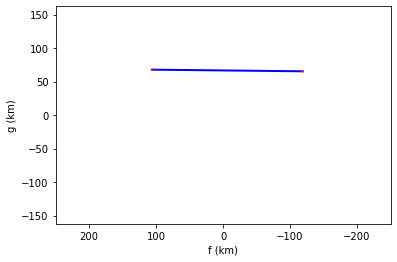

In [15]:
chord.plot_chord(segment='positive', color='blue')
chord.plot_chord(segment='error', color='red')

pl.xlim(+250,-250)
pl.ylim(-250,+250)
pl.show()

**Let's define an** `LightCurve` **with times and fluxes**

In [57]:
chord2 = occ.chords['Hakos']

chord2.lightcurve.set_flux(file='input/lightcurves/lc_example_5.dat', exptime=1.000, usecols=[0,1])

**The** `Chord.plot_chord()` **can also be used with an** `linestyle = exposure` **to see the times where the the chord in fact holds information and the readout time (without information).**

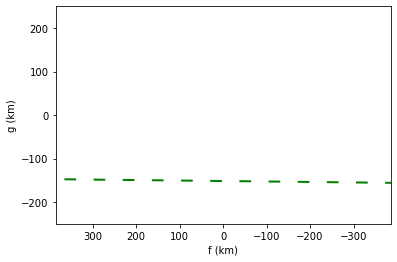

In [59]:
chord2.plot_chord(segment='negative', linestyle='exposure', color='green')

pl.xlim(+250,-250)
pl.ylim(-250,+250)
pl.show()

**Now let's consider all the chords**

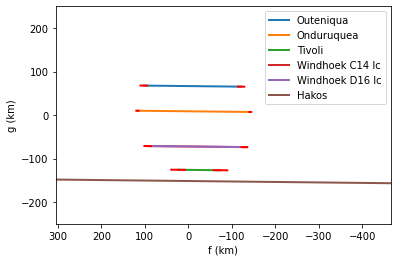

In [46]:
occ.chords.plot_chords()
occ.chords.plot_chords(segment='error', color='red')

pl.legend(loc=1)
pl.xlim(+170,-330)
pl.ylim(-250,+250)
pl.show()

**If there are know time shifts, this can be easily solved using** `LightCurve.dt`

In [10]:
out_lc.dt = -0.150
ond_lc.dt = -0.190
tiv_lc.dt = -0.150
whc_c14_lc.dt = -0.375
whc_d16_lc.dt = +0.000

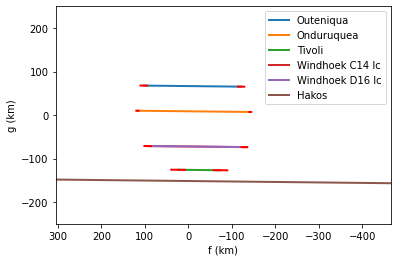

In [48]:
occ.chords.plot_chords()
occ.chords.plot_chords(segment='error', color='red')

pl.legend(loc=1)
pl.xlim(+170,-330)
pl.ylim(-250,+250)
pl.show()

**The user can save these position**

In [16]:
occ.to_file()

<a id="section_3"></a>

## 3. Ellipse fit

The next step is the fitting of an ellipse. The five parameters that describe the ellipse are:

**1.** and **2.** The centre position ($f_0$, $g_0$)

**3.** The apparent equatorial radius, semi-major axix ($a'$)

**4.** The oblatness ($\epsilon' = \frac{a' - b'}{a'}$) 

**5.** The position angle of the pole, semi-minor axix ($P$)

The result of the fit is a `ChiSquare` Object, and its functions can be found at its specific Jupyter-Notebook.

**Here, there is only the manual method, the user should provide the parameters to the fit and also the region for searching each parameters.**

The equation to be minimize is:

$\chi^2 = \sum_{i}^{N} \frac{(r_{i} - r'_{i})^2}{\sigma_i^2 + \sigma_{model}^2}$

where:
- $r_i$ is the radial distance between the $i^{th}$ observed point and the ellipse centre;
- $r'_i$ is the radial distance between the modelled ellipse's $i^{th}$ point and the ellipse centre;
- $\sigma_i$ is the unceartainty of the $i^{th}$ observed point
- $\sigma_{model}$ is the model unceartainty, that is releated to the difference between the real apparent shape of the occultating object and the ellipse model.

In [38]:
occ.fit_ellipse?

Signature: occ.fit_ellipse(**kwargs)
Docstring:
Fits an ellipse to given occultation using given parameters

Parameters:
    required params:
    Each occultation is added as the first arguments directly.
        center_f (int,float): The coordinate in f of the ellipse center. Default=0
        center_g (int,float): The coordinate in g of the ellipse center. Default=0
        equatorial_radius (int,float): The Equatorial radius (semi-major axis) of the ellipse.
        oblateness (int,float): The oblateness of the ellipse. Default=0 (circle)
        position_angle (int,float): The pole position angle of the ellipse in degrees. Default=0
            Zero is in the North direction ('g-positive'). Positive clockwise.

    Parameters interval of fitting. Default values are set to zero.
    Search between (value - dvalue) and (value + dvalue):
        dcenter_f (int,float): Interval for coordinate f of the ellipse center
        dcenter_g (int,float): Interval for coordinate g of the ellips

In [18]:
ellipse_chi2  = occ.fit_ellipse(center_f=-15.046, center_g=-2.495, dcenter_f=10, dcenter_g=20, 
                                equatorial_radius=138, dequatorial_radius=50, oblateness=0.093, 
                                doblateness=0.20, position_angle=90, dposition_angle=90 ,loop=100000,
                                dchi_min=10,number_chi=20000)

Ellipse fit: |████████████████████████████████████████|  - 100% 


Note that here we only used 100000 loops, but it is recommended at least 10 millions for a good sample for each parameter.

In [19]:
print(ellipse_chi2)

Minimum chi-square: 0.216
Number of fitted points: 10
Number of fitted parameters: 5
Minimum chi-square per degree of freedom: 0.043

center_f:
    1-sigma: -13.389 +/- 1.129
    3-sigma: -13.523 +/- 4.344

center_g:
    1-sigma: -2.526 +/- 4.686
    3-sigma: 0.331 +/- 17.107

equatorial_radius:
    1-sigma: 139.493 +/- 6.542
    3-sigma: 152.534 +/- 25.167

oblateness:
    1-sigma: 0.088 +/- 0.040
    3-sigma: 0.144 +/- 0.144

position_angle:
    1-sigma: 130.832 +/- 21.179
    3-sigma: 90.012 +/- 89.971



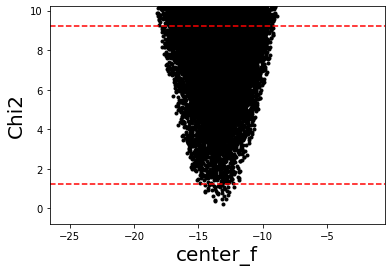

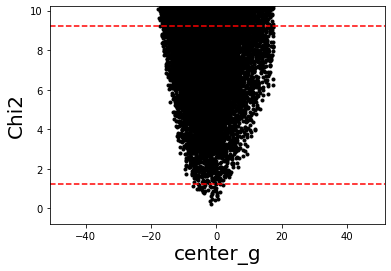

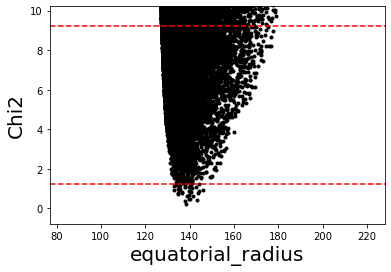

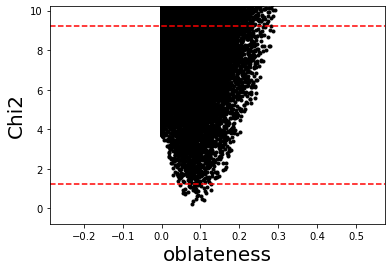

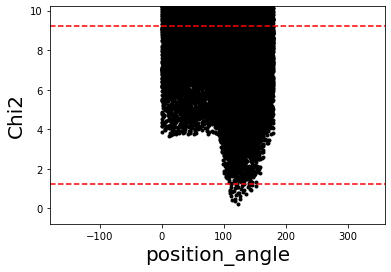

In [20]:
ellipse_chi2.plot_chi2()

**Now, besides the chords we can plot the fitted ellipse**

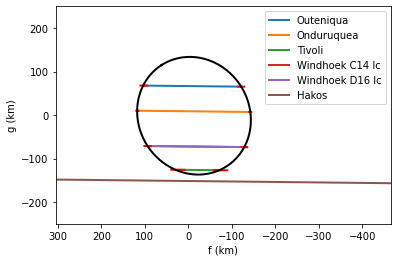

In [21]:
from sora.extra import draw_ellipse

occ.chords.plot_chords()
occ.chords.plot_chords(segment='error', color='red')

#plotting the best fitted ellipse, in black
draw_ellipse(**ellipse_chi2.get_values())

pl.legend(loc=1)
pl.xlim(+170,-330)
pl.ylim(-250,+250)
pl.show()

**Not just the fitted ellipse, but the user can also plot all the ellipses inside an sigma region, for instance within $3\sigma$**

This step will, possible, plot large number of ellipses, this can spend some CPU time.

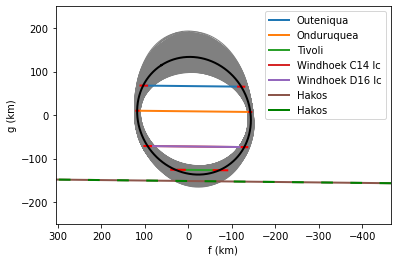

In [45]:
occ.chords.plot_chords()
occ.chords.plot_chords(segment='error', color='red')

#plotting the best fitted ellipse, in black
draw_ellipse(**ellipse_chi2.get_values())

# ploting all the ellipses within 3-sigma, in gray
draw_ellipse(**ellipse_chi2.get_values(sigma=3),alpha=1.0,lw=1)

pl.legend(loc=1)
pl.xlim(+170,-330)
pl.ylim(-250,+250)
pl.show()

**As can be seen, there is some ellipses that cross the Hakos negative chord. They are impossibles solutions as the Hakos lightcurve show no evidence of an occultation. The User can filter this solutions using the** `filter_negative_chord()` **function.**

In [23]:
from sora.occultation.utils import filter_negative_chord

In [24]:
filter_negative_chord?

Signature: filter_negative_chord(chord, chisquare, step=1, sigma=0)
Docstring:
Get points for the ellipse with the given input parameters

Parameters:
    chord (Chord): Chord object, must be associated to an Occultation to work.
    chisquare (ChiSquare): Resulted ChiSquare object of fit_ellipse.
    sigma (int, float): Unceartity of the expected ellipse, in km.
    step (number, 'exposure'): If a number, it corresponds to the step, in seconds, for each point of the chord path.
        The step can also be equal to 'exposure'. In this case, the chord path will consider the lightcurve individual
        times and exptime.
File:      ~/anaconda3/lib/python3.8/site-packages/sora/occultation/utils.py
Type:      function


In [71]:
filter_chi2 = filter_negative_chord(chord = occ.chords['Hakos'], chisquare = ellipse_chi2, step = 0.5)

print(filter_chi2)

Filter chord: Hakos |████████████████████████████████████████|  - 100% 
Minimum chi-square: 0.216
Number of fitted points: 10
Number of fitted parameters: 5
Minimum chi-square per degree of freedom: 0.043

center_f:
    1-sigma: -13.389 +/- 1.129
    3-sigma: -13.523 +/- 4.344

center_g:
    1-sigma: -2.526 +/- 4.686
    3-sigma: 0.331 +/- 17.107

equatorial_radius:
    1-sigma: 139.493 +/- 6.542
    3-sigma: 148.183 +/- 20.816

oblateness:
    1-sigma: 0.088 +/- 0.040
    3-sigma: 0.130 +/- 0.130

position_angle:
    1-sigma: 130.832 +/- 21.179
    3-sigma: 90.012 +/- 89.971



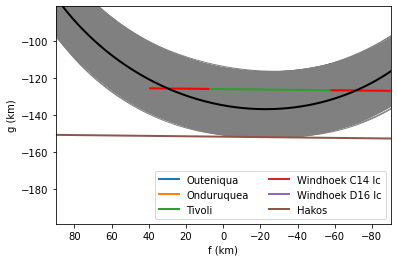

In [78]:
occ.chords.plot_chords()
occ.chords.plot_chords(segment='error', color='red')

#plotting the best fitted ellipse, in black
draw_ellipse(**filter_chi2.get_values())

# ploting all the ellipses within 3-sigma, in gray
draw_ellipse(**filter_chi2.get_values(sigma=3),alpha=1.0,lw=1)

pl.legend(loc=4,ncol=2)
pl.xlim(+90,-90)
pl.ylim(-180,-100)
pl.show()

**The user can set** `step = exposure` **and consider only the region where data was acquired, allowing ellipses that crosses the negative chord during its readout time.**

In [61]:
filter_2_chi2 = filter_negative_chord(chord = occ.chords['Hakos'], chisquare = ellipse_chi2, step='exposure')

print(filter_2_chi2)

Filter chord: Hakos |████████████████████████████████████████|  - 100% 
Minimum chi-square: 0.216
Number of fitted points: 10
Number of fitted parameters: 5
Minimum chi-square per degree of freedom: 0.043

center_f:
    1-sigma: -13.389 +/- 1.129
    3-sigma: -13.523 +/- 4.344

center_g:
    1-sigma: -2.526 +/- 4.686
    3-sigma: 0.331 +/- 17.107

equatorial_radius:
    1-sigma: 139.493 +/- 6.542
    3-sigma: 149.696 +/- 22.328

oblateness:
    1-sigma: 0.088 +/- 0.040
    3-sigma: 0.131 +/- 0.131

position_angle:
    1-sigma: 130.832 +/- 21.179
    3-sigma: 90.012 +/- 89.971



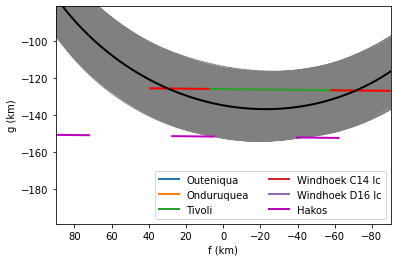

In [77]:
occ.chords.plot_chords(segment='positive')
occ.chords.plot_chords(segment='error', color='red')

chord2.plot_chord(segment='negative', linestyle='exposure', color='m', label='Hakos')

#plotting the best fitted ellipse, in black
draw_ellipse(**filter_2_chi2.get_values())

# ploting all the ellipses within 3-sigma, in gray
draw_ellipse(**filter_2_chi2.get_values(sigma=3),alpha=1.0,lw=1)

pl.legend(loc=4,ncol=2)
pl.xlim(+90,-90)
pl.ylim(-180,-100)
pl.show()

**The radial velocity issue**

During the `LightCurve` fitting, the user has to add the velocity for that light curve. In the initial process, only the geocentric velocity was determined, and only after the fit, a radial velocity can be correctly calculated.

Usually, the light curves' features are dominated by the exposure time. However, in the cases that the fresnel diffraction plays a significant role in it, we suggest that the `LightCurve` fitting procedure should be redone with the correct velocities.

In [29]:
occ.check_velocities()

Outeniqua - Velocity used: 22.004
    Immersion Radial Velocity: 18.810
    Emersion Radial Velocity: 19.229
Onduruquea - Velocity used: 22.004
    Immersion Radial Velocity: 22.271
    Emersion Radial Velocity: 22.273
Tivoli - Velocity used: 22.004
    Immersion Radial Velocity: 10.001
    Emersion Radial Velocity: 6.193
Windhoek C14 lc - Velocity used: 22.004
    Immersion Radial Velocity: 19.217
    Emersion Radial Velocity: 18.621
Windhoek D16 lc - Velocity used: 22.004
    Immersion Radial Velocity: 19.165
    Emersion Radial Velocity: 18.668


<a id="section_4"></a>

## 4. Viewing and saving the results

In the end, we can see the results using Python dictionaries. The `Occultation.fitted_params` will have fitted parameters and their $1\sigma$ uncertainties. The `Occultation.chi2_params` will have some information about the fit and its quality.



In [79]:
occ.fitted_params

{'equatorial_radius': [139.49327194499352, 6.541765358897791],
 'center_f': [-13.389359870265269, 1.1291045125581576],
 'center_g': [-2.525501501624123, 4.685687336727549],
 'oblateness': [0.08820233423598908, 0.039837635483676255],
 'position_angle': [130.83208279183586, 21.179395044814527]}

In [80]:
occ.chi2_params

{'chord_name': ['Outeniqua_immersion',
  'Outeniqua_emersion',
  'Onduruquea_immersion',
  'Onduruquea_emersion',
  'Tivoli_immersion',
  'Tivoli_emersion',
  'Windhoek C14 lc_immersion',
  'Windhoek C14 lc_emersion',
  'Windhoek D16 lc_immersion',
  'Windhoek D16 lc_emersion'],
 'radial_dispersion': array([ 0.32062784, -2.83531516, -1.70773305, -2.17197344, -0.33717119,
        -1.73307545, -1.54104696, -1.22694591, -2.61360828, -0.51106745]),
 'position_angle': array([302.09409395,  58.69635038, 274.28405746,  84.51240035,
        205.96271873, 163.30859441, 238.65455402, 122.9796883 ,
        238.39395674, 122.76183443]),
 'radial_error': array([ 7.15443575,  7.60165533,  2.23532231,  2.45888162, 15.65001123,
        15.65007535,  5.36529308,  5.81243008,  6.25950421,  7.60088696]),
 'chi2_min': 0.2155283253699138,
 'nparam': 5,
 'npts': 10}

**The astrometrical positions obtained can be seen using** `Occultation.new_astrometric_position()`

In [81]:
occ.new_astrometric_position()

Ephemeris offset (km): X = -13.4 km +/- 1.1 km; Y = -2.5 km +/- 4.7 km
Ephemeris offset (mas): da_cos_dec = -1.259 +/- 0.106; d_dec = -0.238 +/- 0.441

Astrometric object position at time 2017-06-22 21:18:48.200
RA = 18 55 15.6523928 +/- 0.113 mas; DEC = -31 31 21.622135 +/- 0.442 mas


**If the user wants the position at a specific time**

In [82]:
occ.new_astrometric_position('2017-06-22 21:21:00.000')

Ephemeris offset (km): X = -13.4 km +/- 1.1 km; Y = -2.5 km +/- 4.7 km
Ephemeris offset (mas): da_cos_dec = -1.259 +/- 0.106; d_dec = -0.238 +/- 0.441

Astrometric object position at time 2017-06-22 21:21:00.000
RA = 18 55 15.6310599 +/- 0.113 mas; DEC = -31 31 21.623530 +/- 0.442 mas


**Also a 'post-fit' occultation map can be created using** `Occultation.plot_occ_map()`

The function that plots the map contains a large number of _kwargs_. They can be used to complete control the map and its tutorial can be found at SORA documentation <a href=https://sora.readthedocs.io/>here</a>.   

In [83]:
occ.plot_occ_map(centermap_delta=[-3500,+400],zoom=20,nameimg='output/map_posfit')

Projected shadow radius = 134.3 km
output/map_posfit.png generated


<img src='output/map_posfit.png' style='width:600px;height:500px'/>

**All this information can also be seen using** `print(Occultation)`

In [84]:
print(occ)

Stellar occultation of star Gaia-DR2 6760223758801661440 by 10199 Chariklo (1997 CU26).

Geocentric Closest Approach: 0.049 arcsec
Instant of CA: 2017-06-22 21:18:48.200
Position Angle: 359.72 deg
Geocentric shadow velocity: -22.00 km / s
Sun-Geocenter-Target angle:  166.42 deg
Moon-Geocenter-Target angle: 149.11 deg


5 positive observations
1 negative observations

###############################################################################
                                     STAR                                      
###############################################################################
Gaia-EDR3 star Source ID: 6760223758801661440
ICRS star coordinate at J2016.0:
RA=18h55m15.65210s +/- 0.0197 mas, DEC=-31d31m21.6676s +/- 0.0180 mas
pmRA=3.556 +/- 0.025 mas/yr, pmDEC=-2.050 +/- 0.020 mas/yr
Plx=0.2121 +/- 0.0228 mas, Rad. Vel.=0.00 +/- 0.00 km/s 

Magnitudes: G: 14.224, B: 14.320, V: 13.530, R: 14.180, J: 12.395, H: 11.781,
            K: 11.627

Apparent diameter from 

**And this can be saved to an ASCII file using** `Occultation.to_log`

In [85]:
occ.to_log('output/Test_occ.log')

!ls output/*.log

output/Test_occ.log


**This Jupyter-Notebook was designed as a tutorial for how to work with the** `Occultation` **Object Class. More information about the other classes, please refer to their specif Jupyter-Notebook. Any further question, please contact the core team: Altair Ramos Gomes Júnior, Bruno Eduardo Morgado, Gustavo Benedetti Rossi, and Rodrigo Carlos Boufleur.**

**The End**